# Visualization

In [1]:
# !mamba install python=3.12.4
# !mamba install cooltools=0.7.0
# !mamba install jupyterlab
# !mamba install jupyter
# !mamba install matplotlib=3.8.0

## Insulation & boundaries

In [1]:
#!pip install --force-reinstall matplotlib==3.8

# import core packages
import warnings
warnings.filterwarnings("ignore")
from itertools import combinations
import os

# import semi-core packages
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
plt.style.use('seaborn-v0_8-poster')
import numpy as np
import pandas as pd
from multiprocessing import Pool

# import open2c libraries
import bioframe

import cooler
import cooltools
from cooltools import insulation
import cooltools.lib.plotting

from packaging import version
if version.parse(cooltools.__version__) < version.parse('0.5.2'):
    raise AssertionError("tutorial relies on cooltools version 0.5.2 or higher,"+
                         "please check your cooltools version and update to the latest")

# count cpus
num_cpus = os.getenv('SLURM_CPUS_PER_TASK')
if not num_cpus:
    num_cpus = os.cpu_count()
num_cpus = int(num_cpus)
print(num_cpus)

10


### Calculating genome-wide contact insulation

In [2]:
# Functions to help with plotting
def pcolormesh_45deg(ax, matrix_c, start=0, resolution=1, *args, **kwargs):
    start_pos_vector = [start+resolution*i for i in range(len(matrix_c)+1)]
    import itertools
    n = matrix_c.shape[0]
    t = np.array([[1, 0.5], [-1, 0.5]])
    matrix_a = np.dot(np.array([(i[1], i[0])
                                for i in itertools.product(start_pos_vector[::-1],
                                                           start_pos_vector)]), t)
    x = matrix_a[:, 1].reshape(n + 1, n + 1)
    y = matrix_a[:, 0].reshape(n + 1, n + 1)
    im = ax.pcolormesh(x, y, np.flipud(matrix_c), *args, **kwargs)
    im.set_rasterized(True)
    return im

from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

In [3]:
import os
os.chdir("./MtoG1_analysis_code")
print(os.getcwd())
!pwd

/Volumes/UKJIN_SSD/MtoG1_analysis_code
/Volumes/UKJIN_SSD/MtoG1_analysis_code


In [4]:
figDir = '../figure/TAD'
os.makedirs(figDir, exist_ok=True)
coolDir = "../data/cool_norm_pooled"
outDir = "../data/TAD"
os.makedirs(outDir, exist_ok=True)

from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import bioframe

INFO:root:creating a Pool of 10 workers
INFO:root:Processing region chr7
INFO:root:Processing region chr5
INFO:root:Processing region chr8
INFO:root:Processing region chr1
INFO:root:Processing region chr4
INFO:root:Processing region chr3
INFO:root:Processing region chr2
INFO:root:Processing region chr10
INFO:root:Processing region chr6
INFO:root:Processing region chr9
INFO:root:Processing region chr11
INFO:root:Processing region chr12
INFO:root:Processing region chr13
INFO:root:Processing region chr14
INFO:root:Processing region chr15
INFO:root:Processing region chr16
INFO:root:Processing region chr17
INFO:root:Processing region chr18
INFO:root:Processing region chr19
INFO:root:Processing region chrM
INFO:root:Processing region chrX
INFO:root:Processing region chrY


5254 5254 3515


INFO:root:creating a Pool of 10 workers
INFO:root:Processing region chr1
INFO:root:Processing region chr4
INFO:root:Processing region chr2
INFO:root:Processing region chr3
INFO:root:Processing region chr6
INFO:root:Processing region chr5
INFO:root:Processing region chr9
INFO:root:Processing region chr10
INFO:root:Processing region chr8
INFO:root:Processing region chr7
INFO:root:Processing region chr11
INFO:root:Processing region chr12
INFO:root:Processing region chr13
INFO:root:Processing region chr14
INFO:root:Processing region chr15
INFO:root:Processing region chr16
INFO:root:Processing region chr17
INFO:root:Processing region chr18
INFO:root:Processing region chr19
INFO:root:Processing region chrM
INFO:root:Processing region chrX
INFO:root:Processing region chrY


4419 4419 2032


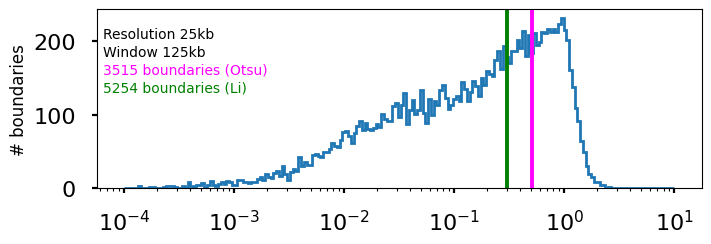

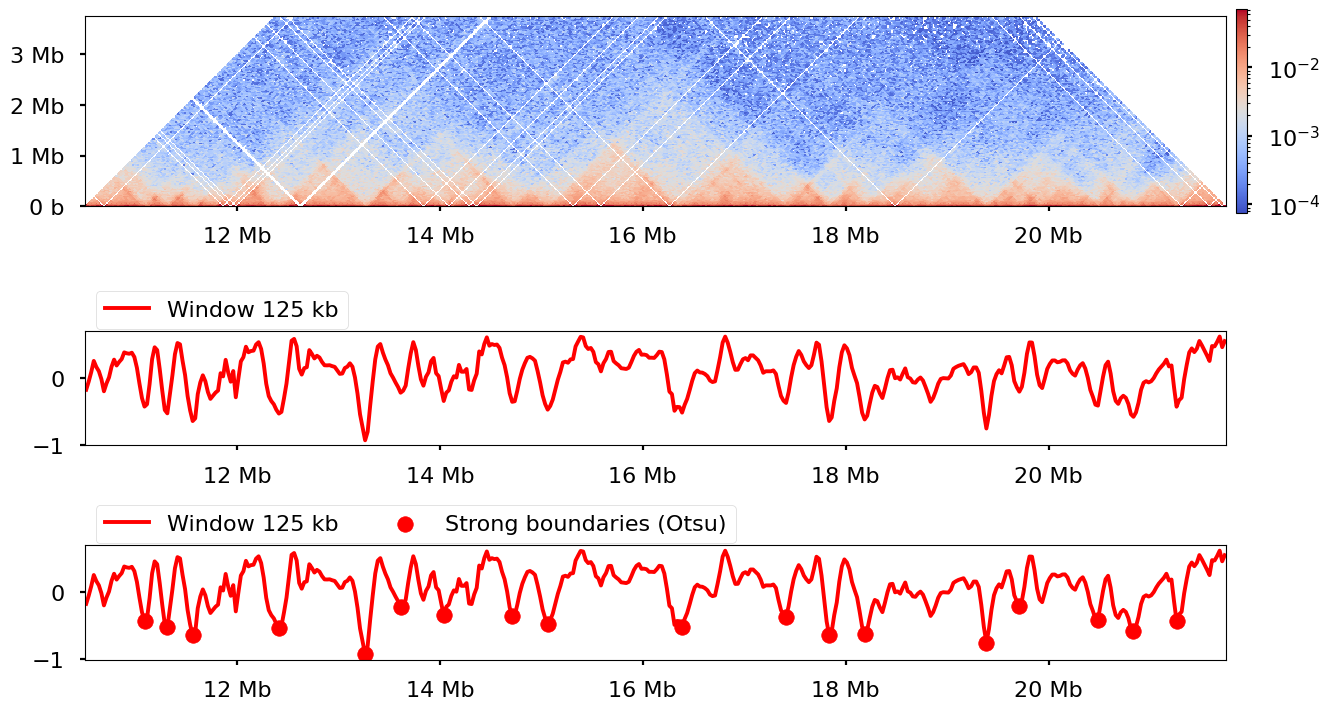

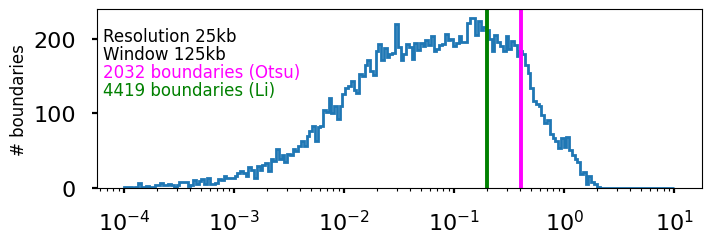

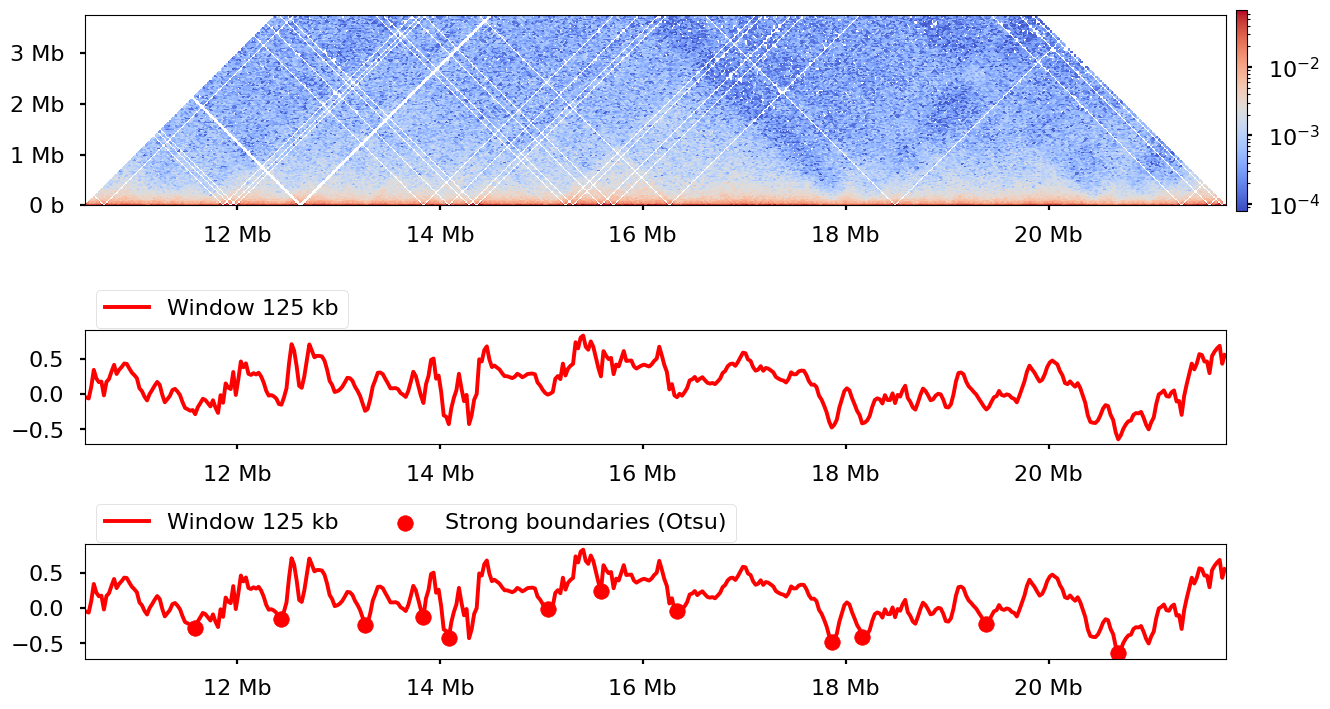

In [9]:

samples = ["G1DMSO_pooled", "G1dTAG_pooled", "G1A485_pooled",
           "GSE178982_AsyncUT_pooled", "GSE178982_AsyncAID_pooled"]
samples = ["EpiG1DMSO_pooled", "EpiG1dTAG_pooled"]

for sample in samples:

    # Import mcool files
    res = 25000
    clr = cooler.Cooler(os.path.join(coolDir, sample + '_' + str(res) + 'bp_KR.cool'))

    # Custom insulation 
    # Calculating insulation score
    windows = [5*res]

    insulation_table = insulation(clr, windows, verbose=True, ignore_diags=2, nproc = num_cpus)

    # Applying Li & Otsu threshold to insulation strength
    from skimage.filters import threshold_li, threshold_otsu

    # NA value need to be masked for threshold functions since Otsu cannot handle NA
    threshold_func_li = lambda x: threshold_li(x[np.isfinite(x)])
    thresholding_func_li = lambda x: x >= threshold_func_li(x)
    threshold_func_otsu = lambda x: threshold_otsu(x[np.isfinite(x)])
    thresholding_func_otsu = lambda x: x >= threshold_func_otsu(x)

    tables = [insulation_table]

    for table in tables:
        for win in windows:
            strong_boundaries = thresholding_func_li(table[f"boundary_strength_{win}"].values)
            table[f"is_boundary_{win}_li"] = strong_boundaries
            strong_boundaries = thresholding_func_otsu(table[f"boundary_strength_{win}"].values)
            table[f"is_boundary_{win}_otsu"] = strong_boundaries

            # Checking the cutoff
    for table in tables:
        for win in windows:
            n_boundaries = table[f'is_boundary_{win}'].sum()
            n_boundaries_li = table[f'is_boundary_{win}_li'].sum()
            n_boundaries_otsu = table[f'is_boundary_{win}_otsu'].sum()
            print(n_boundaries, n_boundaries_li, n_boundaries_otsu)

            # Visualize insulation score and threshold with histogram

    insulation_table.to_csv(os.path.join(outDir, 'TAD_boundaries_' + str(res//1000) + 'kb_' + sample + '.tsv'), sep = '\t', index = False)
    ## PARAMETERS
    histkwargs = dict(
        bins=10**np.linspace(-4,1,200
    ),
        histtype='step',
        lw=2,
    )
    thresholds_li = {}
    thresholds_otsu = {}

    ## PLOTTING
    # List of tables and their names
    tables = [
        (sample, insulation_table)
    ]

    # Plotting
    for table_name, table in tables:
        f, axs = plt.subplots(len(windows), 1, sharex=True, figsize=(7, 7/3), constrained_layout=True)
        
        # Ensure axs is iterable
        if len(windows) == 1:
            axs = [axs]
        for i, (win, ax) in enumerate(zip(windows, axs)):
            ax.hist(
                table[f'boundary_strength_{win}'],
                **histkwargs
            )
            thresholds_li[win] = threshold_func_li(table[f"boundary_strength_{win}"].values)
            thresholds_otsu[win] = threshold_func_otsu(table[f"boundary_strength_{win}"].values)
            n_boundaries_li = (table[f'is_boundary_{win}_li']).sum()
            n_boundaries_otsu = (table[f'is_boundary_{win}_otsu']).sum()
            ax.axvline(thresholds_li[win], c='green')
            ax.axvline(thresholds_otsu[win], c='magenta')
            ax.text(0.01, 0.9,
                    f'Resolution {res//1000}kb',
                    ha='left',
                    va='top',
                    transform=ax.transAxes)
            ax.text(0.01, 0.8,
                    f'Window {win // 1000}kb',
                    ha='left',
                    va='top',
                    transform=ax.transAxes)
            ax.text(0.01, 0.7,
                    f'{n_boundaries_otsu} boundaries (Otsu)',
                    c='magenta',
                    ha='left',
                    va='top',
                    transform=ax.transAxes)
            ax.text(0.01, 0.6,
                    f'{n_boundaries_li} boundaries (Li)',
                    c='green',
                    ha='left',
                    va='top',
                    transform=ax.transAxes)
            ax.set(
                xscale='log',
                ylabel='# boundaries'
            )
        for ax in axs:
            ax.set_ylabel('# boundaries', fontsize=12)
            
        f.savefig(os.path.join(figDir, f'Insulation_threshold_histogram_{table_name}_' + str(res//1000) + 'kb.svg'), format='svg')
        f.savefig(os.path.join(figDir, f'Insulation_threshold_histogram_{table_name}_' + str(res//1000) + 'kb.png'), format='png')


    # Visualizing TAD boundaries along with HiC matrix


    # PARAMETERS
    plt.rcParams['font.size'] = 12
    start = 10_500_000
    end = start+ 90*windows[0]
    region = ('chr2', start, end)
    data = clr.matrix(balance=True).fetch(region)

    #norm = LogNorm(vmax=300, vmin=0.2)
    pos = data[data > 0]
    if pos.size:
        vmin = pos.min()
        vmax = pos.max()*0.2
    else:
        # fallback to something reasonable if your slice is all zeros
        vmin, vmax = 1e-3, 1.0
    norm = LogNorm(vmin=vmin, vmax=vmax)

    # Plotting matrix
    f, ax = plt.subplots(figsize=(15, 15))
    im = pcolormesh_45deg(ax, data, start=region[1], resolution=res, norm=norm, cmap='coolwarm')
    ax.set_aspect(0.5)
    ax.set_ylim(0, 30*windows[0])
    format_ticks(ax, rotate=False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
    plt.colorbar(im, cax=cax)

    # Plotting all insulation score
    insul_region = bioframe.select(insulation_table, region)
    ins_ax = divider.append_axes("bottom", size="30%", pad=0.3, sharex=ax)
    format_ticks(ins_ax, y=False, rotate=False)
    ax.set_xlim(region[1], region[2])

    colors = ['red', 'blue', 'green', 'orange', 'purple']

    i = 0
    winSize = windows[i]
    ins_ax.plot(insul_region[['start', 'end']].mean(axis=1), insul_region[f'log2_insulation_score_{winSize}'], label=f'Window {winSize//1000} kb', color=colors[i])
    ins_ax.legend(bbox_to_anchor=(0., 1.45), loc='upper left', ncol=4);

    # Plotting each boundaries

    ins_ax = divider.append_axes("bottom", size="30%", pad=1, sharex=ax)
    ins_ax.plot(insul_region[['start', 'end']].mean(axis=1),
                insul_region['log2_insulation_score_'+str(windows[i])],
                label=f'Window {(windows[i])//1000} kb',
            color=colors[i])
    boundaries = insul_region[~np.isnan(insul_region[f'boundary_strength_{windows[i]}'])]
    strong_boundaries = boundaries[boundaries[f'is_boundary_{windows[i]}_otsu']]
    ins_ax.scatter(strong_boundaries[['start', 'end']].mean(axis=1),
                strong_boundaries[f'log2_insulation_score_{windows[i]}'], label='Strong boundaries (Otsu)',
                color=colors[i])
    ins_ax.legend(bbox_to_anchor=(0., 1.45), loc='upper left', ncol=4)

    f.savefig(os.path.join(figDir, f'Insulation_threshold_matrix_{table_name}_' + str(res//1000) + 'kb.svg'), format = 'svg')
    f.savefig(os.path.join(figDir, f'Insulation_threshold_matrix_{table_name}_' + str(res//1000) + 'kb.png'), format = 'png')

### Saving insulation score for other analysis

In [7]:
os.makedirs(figDir, exist_ok=True)
coolDir = "../data/cool_norm_pooled"
outDir = "../data/TAD"

# Import mcool files & calculating insulation score
res = 25000
windows = [5*res]


samples = ["G1DMSO_pooled", "G1dTAG_pooled", "G1A485_pooled",
           "GSE178982_AsyncUT_pooled", "GSE178982_AsyncAID_pooled"]
for sample in samples:
    clr = cooler.Cooler(os.path.join(coolDir, sample + '_' + str(res) + 'bp_KR.cool'))
    insulation_table = insulation(clr, windows, verbose=True, ignore_diags=2, nproc = 10)
    insulation_table.to_csv(os.path.join(outDir, 'insulationScore_' + str(res) + 'bp_' + sample + '.tsv'), sep = '\t', index = False)

INFO:root:creating a Pool of 10 workers
INFO:root:Processing region chr1
INFO:root:Processing region chr3
INFO:root:Processing region chr7
INFO:root:Processing region chr2
INFO:root:Processing region chr4
INFO:root:Processing region chr8
INFO:root:Processing region chr10
INFO:root:Processing region chr6
INFO:root:Processing region chr5
INFO:root:Processing region chr9
INFO:root:Processing region chr11
INFO:root:Processing region chr12
INFO:root:Processing region chr13
INFO:root:Processing region chr14
INFO:root:Processing region chr15
INFO:root:Processing region chr16
INFO:root:Processing region chr17
INFO:root:Processing region chr18
INFO:root:Processing region chr19
INFO:root:Processing region chrM
INFO:root:Processing region chrX
INFO:root:Processing region chrY
INFO:root:creating a Pool of 10 workers
INFO:root:Processing region chr2
INFO:root:Processing region chr3
INFO:root:Processing region chr5
INFO:root:Processing region chr1
INFO:root:Processing region chr4
INFO:root:Processin